# Requirements

In [40]:
# Add as many imports as you need.
from datasets import load_dataset

# dataset = load_dataset("csv", data_files="data/wine-reviews.csv")
# dataset

In [41]:
from transformers import AutoTokenizer, DataCollatorWithPadding
# 
# checkpoint = "bert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# # tokenized_texts = tokenizer(dataset["train"]["text"])

In [42]:
# def tokenize(sample):
#     return tokenizer(sample["text"], truncation=True)

In [43]:
from transformers import TrainingArguments

# training_args = TrainingArguments(
#     output_dir="trainer",
#     eval_strategy="epoch",
#     per_device_train_batch_size=8,  # batch size for training
#     per_device_eval_batch_size=8,  # batch size for evaluation
#     metric_for_best_model="f1",
# )

In [44]:
import torch

# Laboratory Exercise - Run Mode (8 points)

## Introduction
This laboratory assignment's primary objective is to fine-tune a pre-trained language model for binary classification on a dataset consisting of wine reviews. The dataset contains two attributes: **description** and **points**. The description is a brief text describing the wine and the points represent a quality metric ranging from 1 to 100. If some wine has at least 90 points it is considered **exceptional**. Your task involves predicting if some wine is **exceptional** based on its review.

## The Wine Reviews Dataset

Load the dataset using the `datasets` library.

In [45]:
# Write your code here. Add as many boxes as you need.
# Za da mozhi da zavrshi nekogash e ona split='train[:100]'
dataset = load_dataset("csv", data_files="data/wine-reviews.csv", split="train[:100]")
dataset

Dataset({
    features: ['description', 'points'],
    num_rows: 100
})

## Target Extraction
Extract the target **exceptional** for each wine review. If some wine has at least 90 points it is considered **exceptional**.

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

In [47]:
dataset

Dataset({
    features: ['description', 'points'],
    num_rows: 100
})

In [49]:
df = dataset.to_pandas()

In [50]:
df['exceptional'] = df['points'].apply(lambda x: 1 if x >= 90 else 0)

In [51]:
df

,description,points,exceptional
0,"Translucent in color, silky in the mouth, this...",85,0
1,"On the palate, this wine is rich and complex, ...",92,1
2,The producer blends 57% Chardonnay from the Ma...,92,1
3,"Pure Baga in all its glory, packed with dry an...",93,1
4,Think of Subsídio as a contribution rather tha...,89,0
...,...,...,...
95,"Crisp and fresh, this is a light wine that is ...",88,0
96,The black-cherry fruit on the nose of this win...,85,0
97,Corte Lenguin's Amarone is less intense aromat...,87,0
98,"Opulent and very minerally, this is deeply fla...",92,1


## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.


In [52]:
X,Y = df['description'], df['exceptional']

In [53]:
X

0     Translucent in color, silky in the mouth, this...
1     On the palate, this wine is rich and complex, ...
2     The producer blends 57% Chardonnay from the Ma...
3     Pure Baga in all its glory, packed with dry an...
4     Think of Subsídio as a contribution rather tha...
                            ...                        
95    Crisp and fresh, this is a light wine that is ...
96    The black-cherry fruit on the nose of this win...
97    Corte Lenguin's Amarone is less intense aromat...
98    Opulent and very minerally, this is deeply fla...
99    Combined with 20% Grenache, this full-bodied, ...
Name: description, Length: 100, dtype: object

In [54]:
Y

0     0
1     1
2     1
3     1
4     0
     ..
95    0
96    0
97    0
98    1
99    1
Name: exceptional, Length: 100, dtype: int64

In [55]:
# Write your code here. Add as many boxes as you need.
X_train, X_test, y_train, y_test = train_test_split(df['description'], df['exceptional'], train_size=0.8, random_state=42)

In [56]:
train_df = pd.concat([X_train,y_train], axis=1)

In [57]:
train_df.columns = ['description', 'label']

In [58]:
train_df

,description,label
55,Oregon is loaded with inexpensive Pinot Noirs ...,1
88,Notions of ripe lemon and mandarin zest play u...,1
26,"Expansive, round and supple in the mouth, this...",1
42,Whiffs of crushed slate and smoke add earthy c...,1
69,Part of the same family business as Philippe G...,1
...,...,...
60,Santo is a creamy Moscato d'Asti with ripe fru...,0
71,A beautifully drinkable rosé sparkling wine fo...,0
14,"Still young and fruity, this wine is totally i...",1
92,Compared to the winery's crisp and light 2014 ...,1


In [59]:
train_df.to_csv("./train.csv")

In [60]:
test_df = pd.concat([X_test,y_test], axis=1)

In [61]:
test_df.columns = ['description', 'label']

In [62]:
test_df.to_csv("./test.csv")

In [63]:
data = load_dataset('csv', data_files={'train': 'train.csv', 'test': 'test.csv'})

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [64]:
data

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'description', 'label'],
        num_rows: 80
    })
    test: Dataset({
        features: ['Unnamed: 0', 'description', 'label'],
        num_rows: 20
    })
})

In [65]:
data = data.remove_columns(['Unnamed: 0'])

In [66]:
data

DatasetDict({
    train: Dataset({
        features: ['description', 'label'],
        num_rows: 80
    })
    test: Dataset({
        features: ['description', 'label'],
        num_rows: 20
    })
})

## Tokenization
Tokenize the texts using the `AutoTokenizer` class.

In [67]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [68]:
def tokenize_function(examples):
    return tokenizer(examples["description"], padding="max_length", truncation=True)

In [69]:
tokenized_datasets = data.map(tokenize_function, batched=True)

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [70]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['description', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 80
    })
    test: Dataset({
        features: ['description', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 20
    })
})

## Fine-tuning a Pre-trained Language Model for Classification
Fine-tune a pre-trained language model for classification on the given dataset.

Define the model using the `AutoModelForSequenceClassification` class.

In [71]:
# Write your code here. Add as many boxes as you need.
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define the traning parameters using the `TrainingArguments` class.

In [72]:
# Write your code here. Add as many boxes as you need.
training_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy="epoch",
    num_train_epochs=1,
    per_device_train_batch_size=4,  # batch size for training
    per_device_eval_batch_size=4,  # batch size for evaluation
)

D:\Fax\LAIP\.venv\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Define the training using the `Trainer` class.

In [73]:
# Write your code here. Add as many boxes as you need.
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
)

Fine-tune (train) the pre-trained lanugage model.

In [74]:
# Write your code here. Add as many boxes as you need.
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.667418


TrainOutput(global_step=20, training_loss=0.6900047302246094, metrics={'train_runtime': 150.1952, 'train_samples_per_second': 0.533, 'train_steps_per_second': 0.133, 'total_flos': 21048884428800.0, 'train_loss': 0.6900047302246094, 'epoch': 1.0})

Use the trained model to make predictions for the test set.

In [76]:
# Write your code here. Add as many boxes as you need.
predictions = trainer.predict(tokenized_datasets["test"])

In [77]:
predictions

PredictionOutput(predictions=array([[ 0.12595968,  0.5988577 ],
       [ 0.01026524,  0.63975453],
       [-0.19139782,  0.58460575],
       [ 0.10445956,  0.6573632 ],
       [-0.20572378,  0.5153418 ],
       [ 0.04380273,  0.66096765],
       [-0.21887337,  0.61314213],
       [-0.19529788,  0.61624825],
       [ 0.13685618,  0.6262393 ],
       [ 0.08850875,  0.59097964],
       [ 0.10446934,  0.62720853],
       [ 0.13587664,  0.614307  ],
       [ 0.0492739 ,  0.6248216 ],
       [-0.17184336,  0.5770661 ],
       [ 0.14694275,  0.6433478 ],
       [ 0.05357217,  0.59484905],
       [-0.13954534,  0.61971146],
       [ 0.04290082,  0.6728156 ],
       [ 0.13390586,  0.64083445],
       [ 0.02207456,  0.6363936 ]], dtype=float32), label_ids=array([0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1]), metrics={'test_loss': 0.6674180626869202, 'test_runtime': 8.4659, 'test_samples_per_second': 2.362, 'test_steps_per_second': 0.591})

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [86]:
from VNP.packages.evaluation import classification_report
import numpy as np
from VNP.packages.vnp_ez import classification_report_ez

In [80]:
# Write your code here. Add as many boxes as you need.
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.60      1.00      0.75        12

    accuracy                           0.60        20
   macro avg       0.30      0.50      0.38        20
weighted avg       0.36      0.60      0.45        20



D:\Fax\LAIP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Fax\LAIP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Fax\LAIP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


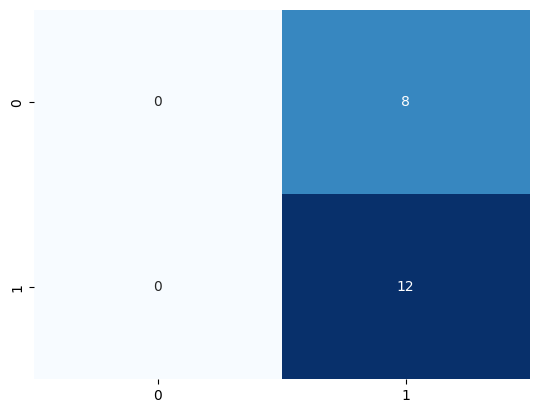

In [88]:
classification_report_ez(labels, preds,show_visualization=True)

# Laboratory Exercise - Bonus Task (+ 2 points)

Implement a simple machine learning pipeline to classify wine reviews as **exceptional** or not. Use TF-IDF vectorization to convert text into numerical features and train a logistic regression. Split the dataset into training and testing sets, fit the pipeline on the training data, and evaluate its performance using metrics such as precision, recall, and F1-score. Analyze the texts to find the most influential words or phrases associated with the **exceptional** wines. Use the coefficients from the logistic regression trained on TF-IDF features to identify the top positive and negative keywords for **exceptional** wines. Present these keywords in a simple table or visualization (e.g., bar chart).

In [90]:
import keras
import pandas as pd

from VNP.packages.data_alalysis import *
from VNP.packages.data_preperation import *
from VNP.packages.missing_values import *
from VNP.packages.visualization import *
from VNP.packages.models import *
from VNP.packages.evaluation import *
from VNP.packages.vnp_ez import *
%load_ext autoreload
%autoreload 2

In [89]:
X_train

55    Oregon is loaded with inexpensive Pinot Noirs ...
88    Notions of ripe lemon and mandarin zest play u...
26    Expansive, round and supple in the mouth, this...
42    Whiffs of crushed slate and smoke add earthy c...
69    Part of the same family business as Philippe G...
                            ...                        
60    Santo is a creamy Moscato d'Asti with ripe fru...
71    A beautifully drinkable rosé sparkling wine fo...
14    Still young and fruity, this wine is totally i...
92    Compared to the winery's crisp and light 2014 ...
51    This 100% varietal wine hails from a site east...
Name: description, Length: 80, dtype: object

In [95]:
type(X_train)

pandas.core.series.Series

In [101]:
# Write your code here. Add as many boxes as you need.
vectorizer = TfidfVectorizer()
regression = LogisticRegression()
model = make_pipeline(vectorizer, regression)
model.fit(X_train,y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression', LogisticRegression())])

In [102]:
predict = model.predict(X_test)

In [103]:
predict

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.60      1.00      0.75        12

    accuracy                           0.60        20
   macro avg       0.30      0.50      0.38        20
weighted avg       0.36      0.60      0.45        20



D:\Fax\LAIP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Fax\LAIP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Fax\LAIP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


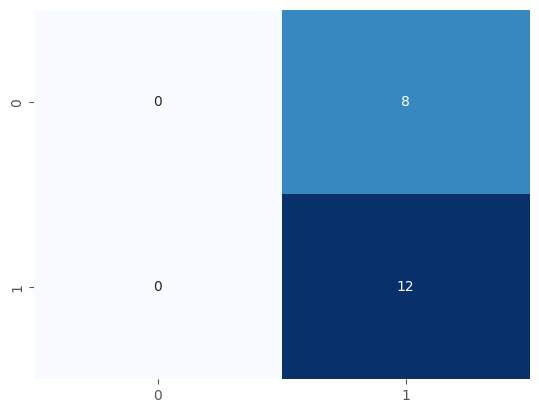

In [104]:
classification_report_ez(y_test,predict, show_visualization=True)

In [114]:
coeff_df = pd.DataFrame({
    "terms": vectorizer.get_feature_names_out(),
    "coeffs": regression.coef_[0],
})

In [116]:
coeff_df.nlargest(10, "coeffs")

,terms,coeffs
925,the,0.463513
924,that,0.337488
627,oak,0.328096
83,at,0.313767
419,green,0.308885
1012,will,0.306484
1025,years,0.299121
253,dark,0.288017
120,black,0.273937
202,clean,0.267050
